In [2]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
from itertools import chain
import seaborn as sns
import gc
import os

import numpy as np
import pandas as pd
from os.path import join
import scipy.sparse as sps

/home/yanxh/anaconda3/envs/scglue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [4]:
exp_id = 'MCAOS'
os.makedirs(f'./cache/{exp_id}', exist_ok=True)

In [5]:
rna = sc.read_h5ad('/home/yanxh/data/MCA/scjoint/atlas_subset/adata_rna_raw.h5ad')
atac = sc.read_h5ad('/home/yanxh/data/MCA/scjoint/data_atlas/adata_atac_raw.h5ad')

In [6]:
# remove duplicated rna.var_names
rna = rna[:, ~rna.var_names.duplicated()].copy()

# rna.var_names = rna.var.var_names.values.astype('str')  # using gene id

In [7]:
prefix = 'nb_norg_nt'

In [8]:
rna.layers["counts"] = rna.X.copy()

In [9]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

In [10]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [11]:
# scglue.data.lsi(atac, n_components=100, n_iter=15)
# np.save(f'./cache/{exp_id}/atac_lsi.npy', atac.obsm['X_lsi']) 

x_lsi = np.load(f'./cache/{exp_id}/atac_lsi.npy')
atac.obsm['X_lsi'] = x_lsi

In [12]:
scglue.data.get_gene_annotation(
    rna, gtf="/home/yanxh/data/GLUE_demo/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
0610005C13Rik,chr7,45567793.0,45575327.0
0610007C21Rik,NaN,NaN,NaN
0610007L01Rik,NaN,NaN,NaN
0610007N19Rik,NaN,NaN,NaN
0610007P08Rik,NaN,NaN,NaN


In [13]:
# exclude NaN rows
rna = rna[:, pd.notna(rna.var["chromStart"])].copy()
rna.shape

(19726, 20670)

In [14]:
split = atac.var_names.str.split(r"[:_]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,chrom,chromStart,chromEnd
chr1_3002478_3002968,chr1,3002478,3002968
chr1_3084739_3085712,chr1,3084739,3085712
chr1_3103576_3104022,chr1,3103576,3104022
chr1_3106871_3107210,chr1,3106871,3107210
chr1_3108932_3109158,chr1,3108932,3109158


In [15]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph: 100%|█████████████████████████████████████████████████████████████████████████████| 20670/20670 [00:03<00:00, 5295.26it/s]


In [17]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [16]:
# rna.write("./cache/HF-50K/rna-pp.h5ad", compression="gzip")
# atac.write("./cache/HF-50K/atac-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, f"./cache/{exp_id}/{prefix}_guidance.graphml.gz")

# training

In [17]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
#     use_cell_type='cell_type'  # None or cell_type
)

In [18]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [19]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [20]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 18865
[INFO] SCGLUEModel: Setting `max_epochs` = 48
[INFO] SCGLUEModel: Setting `patience` = 4
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.423, 'g_kl': 0.006, 'g_elbo': 0.429, 'x_rna_nll': 0.569, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.581, 'x_atac_nll': 0.052, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.053, 'dsc_loss': 0.691, 'vae_loss': 0.651, 'gen_loss': 0.616}, val={'g_nll': 0.412, 'g_kl': 0.006, 'g_elbo': 0.418, 'x_rna_nll': 0.566, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.578, 'x_atac_nll': 0.052, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.053, 'dsc_

2023-02-06 23:06:31,877 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "23"...
[INFO] EarlyStopping: Restoring checkpoint "23"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (33, 34)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 18865
[INFO] SCGLUEModel: Setting `align_burnin` = 8
[INFO] SCGLUEModel: Setting `max_epochs` = 48
[INFO] SCGLUEModel: Setting `patience` = 4
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.432, 'g_kl': 0.006, 'g_elbo': 0.438, 'x_rna_nll': 0.566, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.577, 'x_atac_nll': 0.052, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.052, 'dsc_loss': 0.677, 'vae_loss': 0.647, 'gen_loss': 0.613}

2023-02-06 23:35:04,531 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "25"...
[INFO] EarlyStopping: Restoring checkpoint "25"...


In [16]:
# glue.save(f"./cache/{exp_id}/{prefix}_glue.dill")
glue = scglue.models.load_model(f"./cache/{exp_id}/{prefix}_glue.dill")

[INFO] autodevice: Using GPU 1 as computation device.


In [22]:
### fucking slow
# dx = scglue.models.integration_consistency(
#     glue, {"rna": rna, "atac": atac}, guidance_hvf
# )
# dx

# _ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

# Embedding

In [17]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [21]:
atac.obs['cell_type_bkp'] = atac.obs['cell_type'].values 
atac.obs = atac.obs.drop(columns=['cell_type'])

In [22]:
scglue.data.transfer_labels(rna, atac, "cell_type", use_rep="X_glue")

In [70]:
shr_mask = atac.obs.cell_type_bkp.isin(rna.obs.cell_type.unique())
atac.obs['share_mask'] = shr_mask

atac_pr = atac.obs.cell_type.to_numpy()
atac_gt = atac.obs.cell_type_bkp.to_numpy()

In [71]:
from metrics import osr_evaluator

open_score = 1 - atac.obs.cell_type_confidence.to_numpy()

kn_data_pr = atac_pr[shr_mask]
kn_data_gt = atac_gt[shr_mask]
kn_data_open_score = open_score[shr_mask]

unk_data_open_score = open_score[np.logical_not(shr_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)
closed_acc, os_auroc, os_aupr, oscr

close_acc= 0.4268
AUROC= 0.4701
AUPR= 0.3014
OSCR= 0.1945


(0.42678456647499263,
 0.470122326904438,
 0.30142115209529136,
 0.1945307074672059)

# vis

In [25]:
import umap
def umap_reduce(ad_smp, x_emb='raw'):
    reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=False)
    embedding = reducer.fit_transform(ad_smp.X if x_emb=='raw' else ad_smp.obsm[x_emb])
    ad_smp.obsm["X_umap"] = embedding
    return ad_smp

In [26]:
atac = umap_reduce(atac, 'X_glue')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/home/yanxh/anaconda3/envs/scglue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


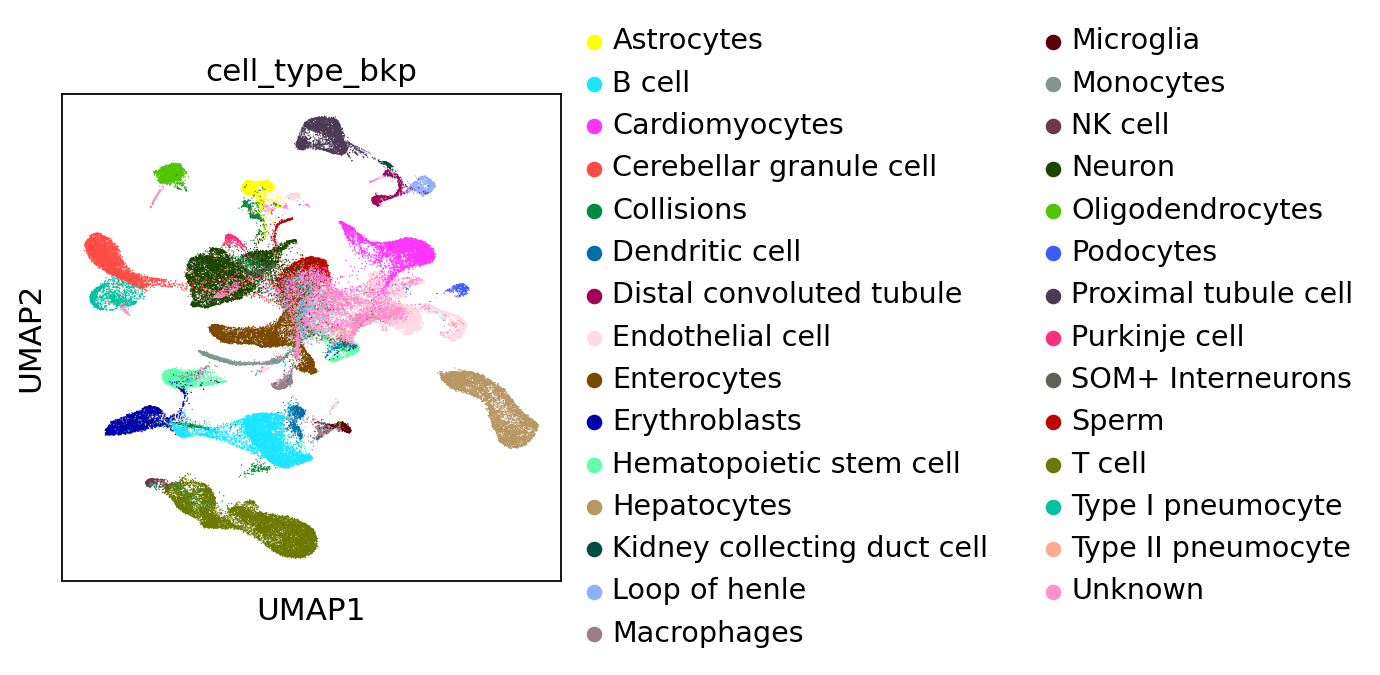

In [27]:
sc.pl.umap(atac, color='cell_type_bkp')